# 1. Inport libraries

* Data processing: numpy, pandas

* Visualization: matplotlib, seaborn

* Hyperparameter tunning: hyperopt

* Maching learning packages:
  * LightGBM: lightgbm
  * scikit-learn

* Model interpretation:
  * SHapley Additive exPlanations: shap
  * Decision tree visualization: dtreeviz

In [1]:
import numpy as np 
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns

import statsmodels.api as sm
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.metrics import confusion_matrix, f1_score, recall_score, precision_score
#from sklearn.metrics import mean_squared_error, f1_score
#from sklearn.model_selection import StratifiedKFold, KFold

import copy
import gc
#import json
#from pathlib import Path
#import sys
#import os
#import pickle
#import joblib

#import pyarrow.parquet as pq
#import pyarrow as pa

from datetime import datetime, date, time

pd.options.display.max_rows = 100
pd.options.display.max_columns = 100

import warnings
warnings.filterwarnings("ignore")

# 2. Load data

For Task 1, load the "nyra_start_table.csv" and "nyra_race_table.csv" CSV files for prediction.

* nyra_start_table.csv - horse/jockey race data
* nyra_race_table.csv - racetrack race data

We can notice that there are three columns exist in all the above four tables, which can be viewed as keys. They are:

* track_id
* race_date
* race_number

In [2]:
race_df = pd.read_csv('nyra_race_table.csv')
start_df = pd.read_csv('nyra_start_table.csv', header=None)
# tracking_df = pd.read_csv('/content/drive/MyDrive/Postgraduate/big-data-derby-2022/nyra_tracking_table.csv')

start_df.columns = ['track_id', 'race_date', 'race_number', 'program_number', 
             'weight_carried', 'jockey', 'odds', 'position_at_finish']
task1_df = start_df.merge(race_df, on=['track_id','race_date', 'race_number'], how='inner')

In [3]:
weather = pd.read_csv('nyc_temperature.csv')
weather['race_date'] = pd.to_datetime(weather['date'])
weather.drop(['date'], axis = 1, inplace = True)

In [4]:
incident = pd.read_csv('nyra-2019-incidents.csv')
incident['race_date'] = pd.to_datetime(incident['incident-date'])
incident.drop(['incident-date'], axis = 1, inplace = True)
incident.rename(columns={'Horse Name':'horse_name'},inplace = True)

In [5]:
horse_id = pd.read_csv("horse_ids.csv", index_col = 0)
horse_name = pd.read_csv("horse_names.csv", index_col = 0)
horse = pd.merge(horse_id, horse_name, on = ['horse_id'], how = 'inner')
horse.rename(columns = {'race':'race_number'},inplace = True)
horse.rename(columns = {'finishing_place':'position_at_finish'},inplace = True)
horse['race_date'] = pd.to_datetime(horse['race_date'])

In [6]:
task1_df['race_date'] = pd.to_datetime(task1_df['race_date'])
task1_df = pd.merge(task1_df, weather, on=['race_date'],how='inner')
task1_df = pd.merge(task1_df, horse, on=['track_id', 'race_date', 'race_number','position_at_finish'],how='inner')
task1_df = pd.merge(task1_df, incident, on=['horse_name'],how='left')

In [7]:
task1_df['precipitation'].replace(to_replace="T", value=0, inplace = True)
task1_df['tavg'] = task1_df['tavg'].astype('int')
task1_df['precipitation'] = task1_df['precipitation'].astype('float')
task1_df['precipitation'] = task1_df['precipitation'].astype('int')

In [8]:
task1_df.drop(['program_number_x'], axis = 1, inplace = True)
task1_df.rename(columns={'program_number_y':'program_number'}, inplace =True)
task1_df.drop(['race_date_y'], axis = 1, inplace = True)
task1_df.rename(columns={'race_date_x':'race_date'}, inplace =True)
task1_df['injury']=np.where(task1_df['incident-type'] != task1_df['incident-type'],0,1)
task1_df.drop(['HDD','CDD','new_snow','snow_depth','tmax','tmin','departure','horse_name','incident-type','injuried-party','pulled','outsome','racing-type','racetrack','where','trainer','jokey','temp','weather=desc','note'],axis = 1, inplace = True)

In [9]:
task1_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14919 entries, 0 to 14918
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   track_id            14919 non-null  object        
 1   race_date           14919 non-null  datetime64[ns]
 2   race_number         14919 non-null  int64         
 3   weight_carried      14919 non-null  int64         
 4   jockey              14919 non-null  object        
 5   odds                14919 non-null  int64         
 6   position_at_finish  14919 non-null  int64         
 7   distance_id         14919 non-null  int64         
 8   course_type         14919 non-null  object        
 9   track_condition     14919 non-null  object        
 10  run_up_distance     14919 non-null  int64         
 11  race_type           14919 non-null  object        
 12  purse               14919 non-null  int64         
 13  post_time           14919 non-null  int64     

# 3. EDA

EDA to get knowledge about how each feature in the files distributed, also might found outliers within the data of each feature.

In [10]:
race_type_dict = {'STK':'Stakes', 'WCL':'Waiver Claiming', 'WMC':'Waiver Maiden Claiming', 'SST':'Starter Stakes', 
          'SHP':'Starter Handicap', 'CLM':'Claiming', 'STR':'Starter Allowance', 'AOC':'Allowance Optionl Claimer', 
          'SOC':'Starter Optional Claimer', 'MCL':'Maiden Claiming', 'ALW':'Allowance', 'MSW':'Maiden Special Weight'}
track_id_dict = dict(AQU='Aqueduct', BEL='Belmont', SAR='Saratoga')
course_type_dict = dict(M='Hurdle', D='Dirt', O='Outer turf', I='Inner turf', T='turf')
track_condition_dict = dict(YL='Yielding', FM='Firm', SY='Sloppy', GD='Good', FT='Fast', MY='Muddy', SF='Soft')

EDA_race_df = race_df.copy()
EDA_race_df['race_type'] = EDA_race_df['race_type'].map(race_type_dict)
EDA_race_df['track_id'] = EDA_race_df['track_id'].map(track_id_dict)
EDA_race_df['course_type'] = EDA_race_df['course_type'].map(course_type_dict)
EDA_race_df['track_condition'] = EDA_race_df['track_condition'].apply(lambda x:x.replace(" ", ''))
EDA_race_df['track_condition'] = EDA_race_df['track_condition'].map(track_condition_dict)
EDA_start_df = start_df.copy()
EDA_start_df['track_id'] = EDA_start_df['track_id'].map(track_id_dict)
print(EDA_start_df.shape, EDA_start_df.shape)

EDA_df = EDA_start_df.merge(EDA_race_df, on=['track_id','race_date','race_number'], how='inner')
print(EDA_df.shape)

(14915, 8) (14915, 8)
(14915, 15)


In [11]:
EDA_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14915 entries, 0 to 14914
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   track_id            14915 non-null  object
 1   race_date           14915 non-null  object
 2   race_number         14915 non-null  int64 
 3   program_number      14915 non-null  object
 4   weight_carried      14915 non-null  int64 
 5   jockey              14915 non-null  object
 6   odds                14915 non-null  int64 
 7   position_at_finish  14915 non-null  int64 
 8   distance_id         14915 non-null  int64 
 9   course_type         14915 non-null  object
 10  track_condition     14915 non-null  object
 11  run_up_distance     14915 non-null  int64 
 12  race_type           14915 non-null  object
 13  purse               14915 non-null  int64 
 14  post_time           14915 non-null  int64 
dtypes: int64(8), object(7)
memory usage: 1.8+ MB


In [12]:
EDA_df.nunique()

track_id                3
race_date             217
race_number            13
program_number         20
weight_carried         35
jockey                178
odds                  656
position_at_finish     14
distance_id            20
course_type             5
track_condition         7
run_up_distance       127
race_type              12
purse                  70
post_time             360
dtype: int64

In [13]:
EDA_df.describe(include=['object'])

,track_id,race_date,program_number,jockey,course_type,track_condition,race_type
count,14915,14915,14915,14915,14915,14915,14915
unique,3,217,20,178,5,7,12
top,Aqueduct,2019-08-24,4,Manuel Franco,Dirt,Fast,Claiming
freq,6191,117,1748,1274,9467,6921,3329


In [14]:
EDA_df.describe(exclude=['object'])

,race_number,weight_carried,odds,position_at_finish,distance_id,run_up_distance,purse,post_time
count,14915.000000,14915.000000,14915.000000,14915.000000,14915.000000,14915.000000,1.491500e+04,14915.000000
mean,5.494200,120.454040,1483.496480,4.486088,725.454241,66.806436,8.367621e+04,412.094200
std,2.826058,3.522007,1956.137156,2.569144,150.055597,36.902299,1.143569e+05,272.818096
min,1.000000,110.000000,0.000000,1.000000,450.000000,0.000000,1.600000e+04,100.000000
25%,3.000000,118.000000,335.000000,2.000000,600.000000,45.000000,4.100000e+04,230.000000
50%,6.000000,120.000000,730.000000,4.000000,700.000000,54.000000,6.200000e+04,347.000000
75%,8.000000,122.000000,1740.000000,6.000000,800.000000,78.000000,8.000000e+04,512.000000
max,13.000000,160.000000,19100.000000,14.000000,2000.000000,280.000000,1.500000e+06,1259.000000


In [15]:
def bar(data, caption, figsize=(12, 6)):
  if data.index.dtype in ['int64', 'int32', 'float64', 'float32']:
    data.index = data.index.astype(str)
  plt.figure(figsize=figsize)
  plt.style.use('seaborn-whitegrid')
  plt.barh(data.index.values, data.values, color="lightseagreen", alpha=0.7)
  for i, v in enumerate(data.values):
    plt.text(v + 3.9, i + .025, str(v), fontsize=10, color="teal", fontweight='bold')#deepskyblue#dodgerblue
  plt.title(caption, fontsize=12, loc='left')
  plt.xticks([])
  plt.grid(visible=True, which='major', axis='both', color='lightgray', linestyle='-', linewidth=0.2)
  plt.rc('ytick', labelsize=10)   
  plt.show()

def hist(data, name, bins=50):
    plt.figure(figsize=(6,4))
    plt.style.use('seaborn-whitegrid')
    plt.hist(data, bins=bins, facecolor='#4ac2fb')
    plt.title(name, fontsize=12)
    plt.axvline(np.array(data.mean()), color='tomato', ls='--', lw=2)
    plt.grid(visible=True, which='major', axis='both', color='lightgray', linestyle='--', linewidth=0.5)
    plt.show()  

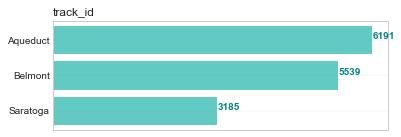

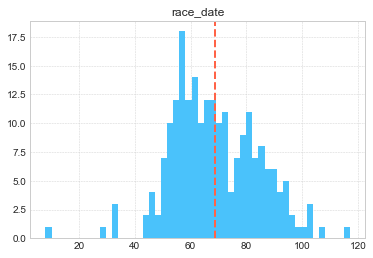

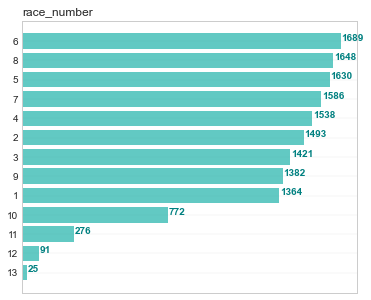

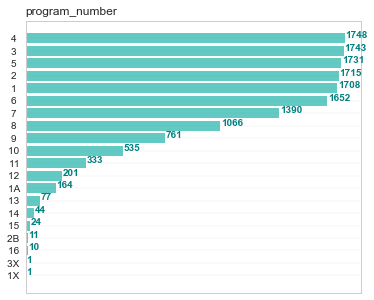

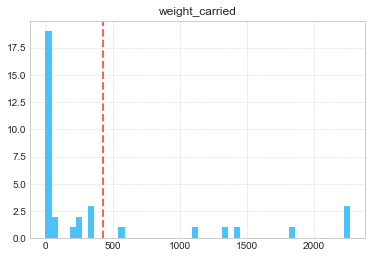

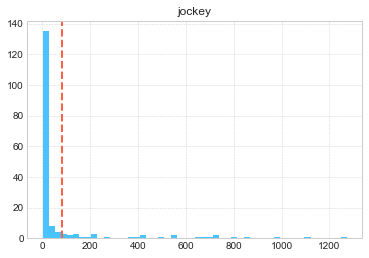

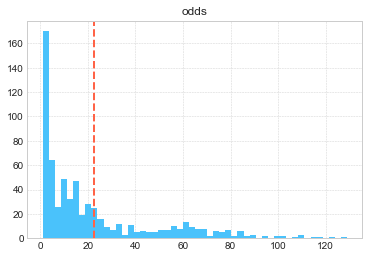

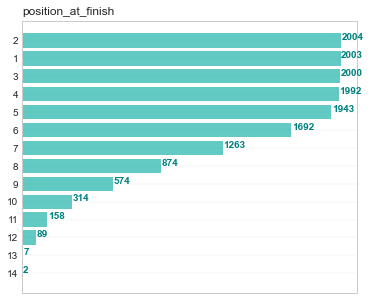

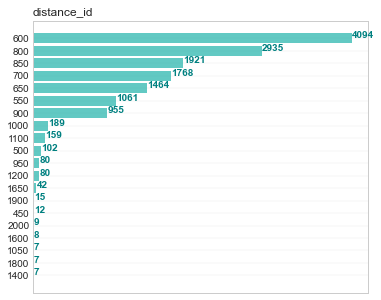

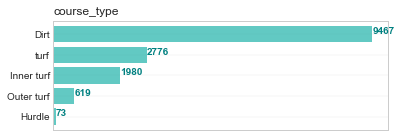

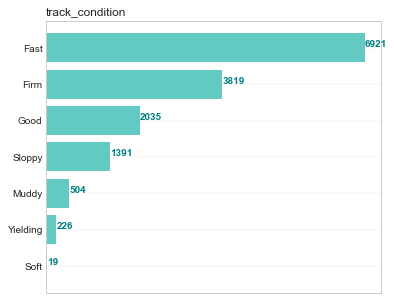

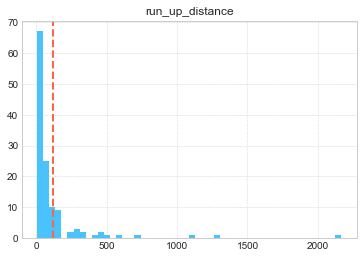

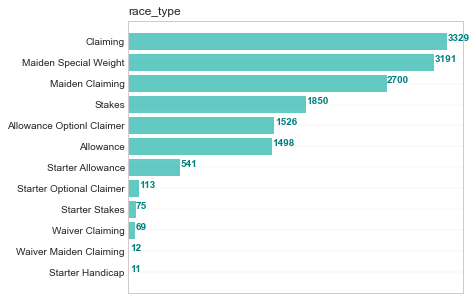

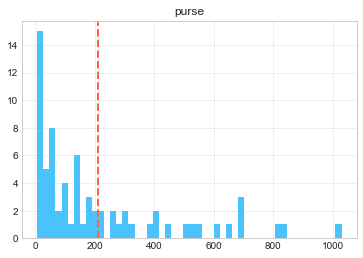

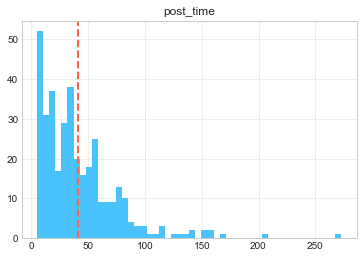

In [16]:
for col in EDA_df.columns:
  data = EDA_df[col].value_counts().sort_values()
  if data.shape[0] <= 5:
    bar(data, col, figsize=(6, 2))
  elif data.shape[0] <= 20:
    bar(data, col, figsize=(6, 5))
  else:
    hist(data, col)
plt.show()

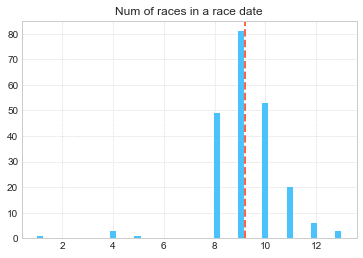

In [17]:
data = EDA_race_df[['race_date', 'race_number']].groupby('race_date').count()['race_number']
hist(data, 'Num of races in a race date')

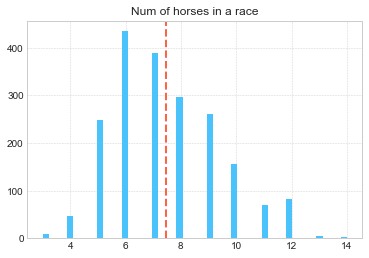

In [18]:
data = EDA_df[['race_date', 'race_number', 'program_number']].groupby(['race_date', 'race_number',]).count()['program_number']
hist(data, 'Num of horses in a race')

# 4. Data Preprocessing

In [19]:
# Check whether there is any null value
task1_df.isna().sum()

track_id              0
race_date             0
race_number           0
weight_carried        0
jockey                0
odds                  0
position_at_finish    0
distance_id           0
course_type           0
track_condition       0
run_up_distance       0
race_type             0
purse                 0
post_time             0
tavg                  0
precipitation         0
program_number        0
horse_id              0
injury                0
dtype: int64

In [20]:
task1_df.sort_values(by=['track_id', 'race_date', 'race_number', 'program_number'], ascending=[True]*4, inplace=True)
task1_df['id'] = range(1, task1_df.shape[0] +1)

1. remove some outliers based on EDA results (task1_df_drop):
  * remove race_date which have less than 8 races
  * remove races which have less than 5 horses or more than 12 horses
  * remove races whose 'course_type' are 'Hurdle' ('M')
  * remove races whose 'track_condition' are 'Soft' ('SF')
  * remove races whose 'distance_id' > 1200
  * remove races whose 'race_type' are in 'Waiver Maiden Claiming', 'Starter Handicap' and 'Waiver Claiming' ('WMC','SHP','WCL')

2. keep outliers (task1_df)

In [21]:
task1_df_drop = task1_df.copy()

# remove race_date which have less than 8 races
race_num = race_df[['race_date', 'race_number']].groupby('race_date').count()
remove_race_dates = race_num[race_num['race_number']<8].index.tolist()
print('The original shape is:', task1_df_drop.shape)
task1_df_drop = task1_df_drop.drop(index=task1_df_drop[task1_df_drop['race_date'].isin(remove_race_dates)].index)
print('Now the shape is:', task1_df_drop.shape)

# remove races which have less than 5 horses or more than 12 horses
horse_num = task1_df_drop[['race_date', 'race_number', 'program_number']].groupby(['race_date', 'race_number',]).count()
remove_horse_num = horse_num[(horse_num['program_number']<5)|(horse_num['program_number']>12)].reset_index().iloc[:, :2]
remove_horse_num = task1_df_drop.merge(remove_horse_num, on=['race_date', 'race_number'], how='inner')
task1_df_drop = task1_df_drop.drop(index = task1_df_drop[task1_df_drop['id'].isin(remove_horse_num['id'].values)].index)
print('Now the shape is:', task1_df_drop.shape)

# remove races whose 'course_type' are 'Hurdle' ('M')
task1_df_drop = task1_df_drop.drop(index=task1_df_drop[task1_df_drop['course_type'].isin(['M',])].index)
print('Now the shape is:', task1_df_drop.shape)

# remove races whose 'track_condition' are 'Soft' ('SF')
task1_df_drop = task1_df_drop.drop(index=task1_df_drop[task1_df_drop['track_condition'].isin(['SF',])].index)
print('Now the shape is:', task1_df_drop.shape)

# remove races whose 'distance_id' > 1200
task1_df_drop = task1_df_drop.drop(index=task1_df_drop[task1_df_drop['distance_id']>1200].index)
print('Now the shape is:', task1_df_drop.shape)

# remove races whose 'race_type' are in 'Waiver Maiden Claiming', 'Starter Handicap' and 'Waiver Claiming' ('WMC','SHP','WCL')
race_types_to_remove = []
for k, v in race_type_dict.items():
  if v in ['Waiver Maiden Claiming', 'Starter Handicap', 'Waiver Claiming']:
    race_types_to_remove.append(k)
task1_df_drop = task1_df_drop.drop(index=task1_df_drop[task1_df_drop['race_type'].isin(['WMC','SHP','WCL'])].index)
print('Now the shape is:', task1_df_drop.shape)

The original shape is: (14919, 20)
Now the shape is: (14784, 20)
Now the shape is: (14479, 20)
Now the shape is: (14416, 20)
Now the shape is: (14416, 20)
Now the shape is: (14401, 20)
Now the shape is: (14309, 20)


# 5. Target Engineering

Use position_at_finish (An integer of the horse's finishing position) to engineer a binary target to indicate if a jockey won a race or not.

In [22]:
task1_df_drop = task1_df_drop.sort_values(by=['track_id', 'race_date', 'race_number', 'program_number'], ascending=[True]*4)

1. Method 1 (Win): If position_at_finish is 1, it means that this jockey won the first place in a race, the target is 1; otherwise the target is 0. ('target_win)

2. Method 2 (Place): If position_at_finish is 1, 2 or 3 , it means that the jockey won one of the first three places in a race, the target is 1; otherwise the target is 0. ('target_place')

In [23]:
task1_df_drop = task1_df_drop.copy()

task1_df_drop['target_win'] = (task1_df_drop['position_at_finish']==1).astype(int)
print('If use method one (Win): \n')
print(task1_df_drop['target_win'].value_counts())
print(task1_df_drop['target_win'].value_counts()/task1_df_drop.shape[0])

task1_df_drop['target_plc'] = (task1_df_drop['position_at_finish']<4).astype(int)
print('If use method two (Place): \n')
print(task1_df_drop['target_plc'].value_counts())
print(task1_df_drop['target_plc'].value_counts()/task1_df_drop.shape[0])

If use method one (Win): 

0    12407
1     1902
Name: target_win, dtype: int64
0    0.867077
1    0.132923
Name: target_win, dtype: float64
If use method two (Place): 

0    8608
1    5701
Name: target_plc, dtype: int64
0    0.601579
1    0.398421
Name: target_plc, dtype: float64


# 6. Feature Engineering
* create dummy features for categorical features
* create features from race_date and post_time
* create descriptive statistical features
* jockey: create id for jockey
* jockey's previous win rate and place rate
* horse's previous win rate and place rate

## Create dummy features for categorical features

In [24]:
def post_time_(x):
  #morning: before 1200, 0
  #noon: 1200-1430, 1
  #afternoon: 1430-1830, 2
  #evening: 1830-2400, 3
    
  v = '1200'
  if (x is None)|(x is np.nan):
    v = '1200'
  else:
    x = str(x)
    x1_, x2_ = int(x[:-2]), int(x[-2:])
    if x1_ < 10:
      x1_ = x1_ + 12
    v = int(f'{x1_}{x2_}')
  #r = -1
  if v < 1200:
    r = 0
  elif v < 1430:
    r = 1
  elif v < 1830:
    r = 2
  else:
    r = 3
  return r

In [25]:
# create dummy features for categorical features

task1_df_drop['race_date'] = pd.to_datetime(task1_df_drop['race_date'])
task1_df_drop['weekday'] = task1_df_drop['race_date'].dt.weekday
task1_df_drop['month'] = task1_df_drop['race_date'].dt.month
task1_df_drop['post_time2'] = task1_df_drop['post_time'].apply(post_time_)

for column in ['track_id', 'course_type', 'track_condition', 'race_type']:
  dummies_ = pd.get_dummies(task1_df_drop[column])
  dummy_feats_ =  [f'{column}={cc}' for cc in dummies_.columns]
  dummies_.columns = dummy_feats_
  task1_df_drop[dummy_feats_] = dummies_.values

jockeys = task1_df_drop['jockey'].unique().tolist()
jockey_ids = pd.DataFrame(index=jockeys, data={'jockey_id': range(1, len(jockeys)+1)}).to_dict()['jockey_id']
task1_df_drop['jockey_id'] = task1_df_drop['jockey'].map(jockey_ids)

horses = task1_df_drop['horse_id'].unique().tolist()
horse_ids = pd.DataFrame(index=horses, data={'horse_id': range(1, len(horses)+1)}).to_dict()['horse_id']
task1_df_drop['horse_id'] = task1_df_drop['horse_id'].map(horse_ids)

print('Now the shape is:', task1_df_drop.shape)

Now the shape is: (14309, 49)


## create descriptive statistical features

### jockey

* the descriptive statistical features of jockey's performances
  * win rate before current rate_date
  * place rate before current rate_date
  * race count before current rate_date
  * win rate/place rate of current course type/track

In [26]:
perf = task1_df_drop[['jockey', 'race_date', 'position_at_finish']].groupby(['jockey', 'race_date']).count()
perf.columns = ['perf_cnt']
wins = task1_df_drop.loc[task1_df_drop['position_at_finish']<2,['jockey','race_date','position_at_finish']].groupby(['jockey','race_date']).count()
wins.columns = ['win_cnt']
places = task1_df_drop.loc[task1_df_drop['position_at_finish']<4,['jockey','race_date','position_at_finish']].groupby(['jockey','race_date']).count()
places.columns=['place_cnt']

perf = perf.reset_index()
wins = wins.reset_index()
places = places.reset_index()
perf.sort_values(by=['jockey', 'race_date'], ascending=[True]*2, inplace=True)
wins.sort_values(by=['jockey', 'race_date'], ascending=[True]*2, inplace=True)
places.sort_values(by=['jockey', 'race_date'], ascending=[True]*2, inplace=True)

perf = perf.merge(wins, on=['jockey', 'race_date'], how='left')
perf = perf.merge(places, on=['jockey', 'race_date'], how='left')
perf.fillna(0, inplace=True)

cumsum = perf.groupby('jockey').cumsum()
perf['perf_cumsum'] = cumsum['perf_cnt']
perf['win_rate'] = cumsum['win_cnt']/cumsum['perf_cnt']
perf['place_rate'] = cumsum['place_cnt']/cumsum['perf_cnt']

perf_ = perf.groupby('jockey').shift(1)
for column in perf_.columns:
    perf[f'pre_{column}'] = perf_[column]
perf.fillna(0, inplace=True)

task1_df_drop = task1_df_drop.merge(perf, on=['jockey', 'race_date'], how='left')
print('Now the shape is:', task1_df_drop.shape)

Now the shape is: (14309, 62)


In [27]:
task1_df_drop['win'] = (task1_df_drop['position_at_finish']<2).astype(int)
task1_df_drop['place'] = (task1_df_drop['position_at_finish']<4).astype(int)

In [28]:
jockeys = task1_df_drop['jockey'].value_counts()[task1_df_drop['jockey'].value_counts()>=10].index.values.tolist()
race_days = race_df['race_date'].unique().tolist()
race_days.sort()

data = pd.pivot_table(task1_df_drop, index=['race_date'], columns=['jockey'], values=['win', 'place'], 
               aggfunc={'win': [np.sum, np.size], 'place': np.sum} )
data.sort_index(ascending=True, inplace=True)

dfs_pre = []
for jk in jockeys:
  data_i = data[[('place','sum',jk), ('win','size',jk), ('win','sum',jk)]].fillna(0)
  data_i.columns = ['place', 'run', 'win']

  data_i['plc_sum'] = data_i['place'].rolling(31).apply(lambda x: x[:-1].sum())
  data_i['win_sum'] = data_i['win'].rolling(31).apply(lambda x: x[:-1].sum())
  data_i['run_sum'] = data_i['run'].rolling(31).apply(lambda x: x[:-1].sum())

  data_i['plc_rate'] = data_i['plc_sum'] / data_i['run_sum']
  data_i['win_rate'] = data_i['win_sum'] / data_i['run_sum']
  data_i['jockey'] = jk
    
  for col in ['plc_rate', 'win_rate']:
    for i in [3, 5, 10]:
      data_i[f'{col}_diff{i}'] = data_i[col].diff(i)
  dfs_pre.append(data_i.reset_index())
df_pre = pd.concat(dfs_pre)

new_cols = []
for col in df_pre.columns:
    if col in ['jockey', 'race_date']:
        new_cols.append(col)
    else:
        new_cols.append(f'pre31_{col}')
df_pre.columns = new_cols

task1_df_drop = task1_df_drop.merge(df_pre, on=['jockey', 'race_date'], how='left')

task1_df_drop = task1_df_drop.replace([-np.inf, np.inf], np.nan)
task1_df_drop = task1_df_drop.fillna(0)
print(task1_df_drop.isna().sum()[task1_df_drop.isna().sum()>0])

print('Now the shape is:', task1_df_drop.shape)

Series([], dtype: int64)
Now the shape is: (14309, 78)


### horse

* the descriptive statistical features of horse's performances
  * win rate before current rate_date
  * place rate before current rate_date
  * race count before current rate_date
  * win rate/place rate of current course type/track

In [29]:
hperf = task1_df_drop[['horse_id', 'race_date', 'position_at_finish']].groupby(['horse_id', 'race_date']).count()
hperf.columns = ['hperf_cnt']
hwins = task1_df_drop.loc[task1_df_drop['position_at_finish']<2,['horse_id','race_date','position_at_finish']].groupby(['horse_id','race_date']).count()
hwins.columns = ['hwin_cnt']
hplaces = task1_df_drop.loc[task1_df_drop['position_at_finish']<4,['horse_id','race_date','position_at_finish']].groupby(['horse_id','race_date']).count()
hplaces.columns=['hplace_cnt']

hperf = hperf.reset_index()
hwins = hwins.reset_index()
hplaces = hplaces.reset_index()
hperf.sort_values(by=['horse_id', 'race_date'], ascending=[True]*2, inplace=True)
hwins.sort_values(by=['horse_id', 'race_date'], ascending=[True]*2, inplace=True)
hplaces.sort_values(by=['horse_id', 'race_date'], ascending=[True]*2, inplace=True)

hperf = hperf.merge(hwins, on=['horse_id', 'race_date'], how='left')
hperf = hperf.merge(hplaces, on=['horse_id', 'race_date'], how='left')
hperf.fillna(0, inplace=True)

cumsum = hperf.groupby('horse_id').cumsum()
hperf['hperf_cumsum'] = cumsum['hperf_cnt']
hperf['hwin_rate'] = cumsum['hwin_cnt']/cumsum['hperf_cnt']
hperf['hplace_rate'] = cumsum['hplace_cnt']/cumsum['hperf_cnt']

hperf_ = hperf.groupby('horse_id').shift(1)
for column in hperf_.columns:
    hperf[f'pre_{column}'] = hperf_[column]
hperf.fillna(0, inplace=True)

task1_df_drop = task1_df_drop.merge(hperf, on=['horse_id', 'race_date'], how='left')
print('Now the shape is:', task1_df_drop.shape)

Now the shape is: (14309, 91)


In [30]:
task1_df_drop['win'] = (task1_df_drop['position_at_finish']<2).astype(int)
task1_df_drop['place'] = (task1_df_drop['position_at_finish']<4).astype(int)

In [31]:
horses = task1_df_drop['horse_id'].value_counts()[task1_df_drop['horse_id'].value_counts()>=10].index.values.tolist()
race_days = race_df['race_date'].unique().tolist()
race_days.sort()

hdata = pd.pivot_table(task1_df_drop, index=['race_date'], columns=['horse_id'], values=['win', 'place'], 
               aggfunc={'win': [np.sum, np.size], 'place': np.sum} )
hdata.sort_index(ascending=True, inplace=True)

dfs_hpre = []
for jk in horses:
  hdata_i = hdata[[('place','sum',jk), ('win','size',jk), ('win','sum',jk)]].fillna(0)
  hdata_i.columns = ['place', 'run', 'win']

  hdata_i['hplc_sum'] = hdata_i['place'].rolling(31).apply(lambda x: x[:-1].sum())
  hdata_i['hwin_sum'] = hdata_i['win'].rolling(31).apply(lambda x: x[:-1].sum())
  hdata_i['hrun_sum'] = hdata_i['run'].rolling(31).apply(lambda x: x[:-1].sum())

  hdata_i['hplc_rate'] = hdata_i['hplc_sum'] / hdata_i['hrun_sum']
  hdata_i['hwin_rate'] = hdata_i['hwin_sum'] / hdata_i['hrun_sum']
  hdata_i['horse_id'] = jk
    
  for col in ['hplc_rate', 'hwin_rate']:
    for i in [3, 5, 10]:
      hdata_i[f'{col}_diff{i}'] = hdata_i[col].diff(i)
  dfs_hpre.append(hdata_i.reset_index())
df_hpre = pd.concat(dfs_hpre)

new_cols = []
for col in df_hpre.columns:
    if col in ['horse_id', 'race_date']:
        new_cols.append(col)
    else:
        new_cols.append(f'pre31_{col}')
df_hpre.columns = new_cols

task1_df_drop = task1_df_drop.merge(df_hpre, on=['horse_id', 'race_date'], how='left')

task1_df_drop = task1_df_drop.replace([-np.inf, np.inf], np.nan)
task1_df_drop = task1_df_drop.fillna(0)
print(task1_df_drop.isna().sum()[task1_df_drop.isna().sum()>0])

print('Now the shape is:', task1_df_drop.shape)

Series([], dtype: int64)
Now the shape is: (14309, 105)


In [32]:
task1_df_drop.drop(['pre_race_date_y'], axis = 1, inplace = True)
task1_df_drop.rename(columns={'pre_race_date_x':'pre_race_date'}, inplace =True)
task1_df_drop.drop(['pre31_place_y'], axis = 1, inplace = True)
task1_df_drop.rename(columns={'pre31_place_x':'pre31_place'}, inplace =True)
task1_df_drop.drop(['pre31_run_y'], axis = 1, inplace = True)
task1_df_drop.rename(columns={'pre31_run_x':'pre31_run'}, inplace =True)
task1_df_drop.drop(['pre31_win_y'], axis = 1, inplace = True)
task1_df_drop.rename(columns={'pre31_win_x':'pre31_win'}, inplace =True)

In [33]:
pd.options.display.max_info_columns = 200
task1_df_drop.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14309 entries, 0 to 14308
Data columns (total 101 columns):
 #    Column                  Non-Null Count  Dtype         
---   ------                  --------------  -----         
 0    track_id                14309 non-null  object        
 1    race_date               14309 non-null  datetime64[ns]
 2    race_number             14309 non-null  int64         
 3    weight_carried          14309 non-null  int64         
 4    jockey                  14309 non-null  object        
 5    odds                    14309 non-null  int64         
 6    position_at_finish      14309 non-null  int64         
 7    distance_id             14309 non-null  int64         
 8    course_type             14309 non-null  object        
 9    track_condition         14309 non-null  object        
 10   run_up_distance         14309 non-null  int64         
 11   race_type               14309 non-null  object        
 12   purse                   14309 

# 7. Models for prediction

* create training and testing data
* Define multiple models for prediction
* Compare the performance of models

In [34]:
task1_df_drop.columns.values

array(['track_id', 'race_date', 'race_number', 'weight_carried', 'jockey',
       'odds', 'position_at_finish', 'distance_id', 'course_type',
       'track_condition', 'run_up_distance', 'race_type', 'purse',
       'post_time', 'tavg', 'precipitation', 'program_number', 'horse_id',
       'injury', 'id', 'target_win', 'target_plc', 'weekday', 'month',
       'post_time2', 'track_id=AQU', 'track_id=BEL', 'track_id=SAR',
       'course_type=D', 'course_type=I', 'course_type=O', 'course_type=T',
       'track_condition=FM ', 'track_condition=FT ',
       'track_condition=GD ', 'track_condition=MY ',
       'track_condition=SF ', 'track_condition=SY ',
       'track_condition=YL ', 'race_type=ALW', 'race_type=AOC',
       'race_type=CLM', 'race_type=MCL', 'race_type=MSW', 'race_type=SOC',
       'race_type=SST', 'race_type=STK', 'race_type=STR', 'jockey_id',
       'perf_cnt', 'win_cnt', 'place_cnt', 'perf_cumsum', 'win_rate',
       'place_rate', 'pre_race_date', 'pre_perf_cnt', 'pre_win

In [35]:
features = ['weight_carried', 'odds', 'distance_id', 'run_up_distance', 'tavg', 'precipitation','horse_id',
       'injury','purse', 'weekday', 'month', 
       'post_time2', 'track_id=AQU', 'track_id=BEL', 'track_id=SAR', 'course_type=D', 
       'course_type=I', 'course_type=O', 'course_type=T', 'track_condition=FM ', 'track_condition=FT ', 
       'track_condition=GD ', 'track_condition=MY ', 'track_condition=SF ', 'track_condition=SY ',
       'track_condition=YL ', 'race_type=ALW', 'race_type=AOC', 'race_type=CLM', 'race_type=MCL', 
       'race_type=MSW', 'race_type=SOC', 'race_type=SST', 'race_type=STK', 'race_type=STR', 'jockey_id', 
       'pre_perf_cnt', 'pre_win_cnt', 'pre_place_cnt', 'pre_perf_cumsum', 'pre_win_rate', 'pre_place_rate',
       'pre31_place', 'pre31_run', 'pre31_win', 'pre31_plc_sum', 'pre31_win_sum', 'pre31_run_sum', 
       'pre31_plc_rate', 'pre31_win_rate', 'pre31_plc_rate_diff3', 'pre31_plc_rate_diff5', 
       'pre31_plc_rate_diff10', 'pre31_win_rate_diff3', 'pre31_win_rate_diff5', 'pre31_win_rate_diff10','hperf_cnt', 'hwin_cnt', 'hplace_cnt',
       'hperf_cumsum', 'hwin_rate', 'hplace_rate', 'pre_hperf_cnt',
       'pre_hwin_cnt', 'pre_hplace_cnt', 'pre_hperf_cumsum',
       'pre_hwin_rate', 'pre_hplace_rate', 'pre31_hplc_sum',
       'pre31_hwin_sum', 'pre31_hrun_sum', 'pre31_hplc_rate',
       'pre31_hwin_rate', 'pre31_hplc_rate_diff3',
       'pre31_hplc_rate_diff5', 'pre31_hplc_rate_diff10',
       'pre31_hwin_rate_diff3', 'pre31_hwin_rate_diff5',
       'pre31_hwin_rate_diff10']
len(features)

79

In [36]:
train_start, train_end = '2019-02-01', '2019-10-15'
test_start, test_end = '2019-10-15', '2020-01-01'

df_train = task1_df_drop[(task1_df_drop['race_date']>=train_start) & (task1_df_drop['race_date']<train_end)].copy()
df_test = task1_df_drop[(task1_df_drop['race_date']>=test_start) & (task1_df_drop['race_date']<test_end)].copy()

print(df_train.shape, df_test.shape)

(10409, 101) (3093, 101)


In [37]:
X_train, X_test = df_train[features], df_test[features]
y_train_win, y_test_win = df_train['target_win'], df_test['target_win']
y_train_plc, y_test_plc = df_train['target_plc'], df_test['target_plc']
print(X_train.shape, X_test.shape, y_train_win.shape, y_test_win.shape, y_train_plc.shape, y_test_plc.shape)

(10409, 79) (3093, 79) (10409,) (3093,) (10409,) (3093,)


In [38]:
win_models, plc_models = {}, {}

## **Model 1: Logistic Regression**

In [39]:
from sklearn.linear_model import LogisticRegression

logistic_reg = LogisticRegression()
logistic_reg.fit(X_train, y_train_win)
y_pred_win_log = logistic_reg.predict(X_test)

cm_win_log = confusion_matrix(y_test_win, y_pred_win_log, labels=[1, 0])
auc_win_log = roc_auc_score(y_test_win, y_pred_win_log)
acc_win_log = accuracy_score(y_test_win, y_pred_win_log)
f1_win_log = f1_score(y_test_win, y_pred_win_log, labels=[1, 0])
recall_win_log = recall_score(y_test_win, y_pred_win_log, labels=[1, 0])
precision_win_log = precision_score(y_test_win, y_pred_win_log, labels=[1, 0])

print('For predicting Win:')
print('The confusion matrix of Logistic Regression:\n', cm_win_log)
print(f'The auc_score of Logistic Regression: {auc_win_log: .05f}')
print(f'The acc_score of Logistic Regression: {acc_win_log: .05f}')
print(f'The F-measure of Logistic Regression: {f1_win_log: .05f}')
print(f'The recall of Logistic Regression: {recall_win_log: .05f}')
print(f'The precision of Logistic Regression: {precision_win_log: .05f}')

win_models['LogisticRegression'] = [cm_win_log, auc_win_log, acc_win_log, f1_win_log, recall_win_log, precision_win_log]
#win_models['LogisticRegression'] = [cm_win_log, auc_win_log, acc_win_log, precision_win_log]

For predicting Win:
The confusion matrix of Logistic Regression:
 [[   0  380]
 [   0 2713]]
The auc_score of Logistic Regression:  0.50000
The acc_score of Logistic Regression:  0.87714
The F-measure of Logistic Regression:  0.00000
The recall of Logistic Regression:  0.00000
The precision of Logistic Regression:  0.00000


In [40]:
logistic_reg = LogisticRegression()
logistic_reg.fit(X_train, y_train_plc)
y_pred_plc_log = logistic_reg.predict(X_test)

cm_plc_log = confusion_matrix(y_test_plc, y_pred_plc_log, labels=[1, 0])
auc_plc_log = roc_auc_score(y_test_plc, y_pred_plc_log)
acc_plc_log = accuracy_score(y_test_plc, y_pred_plc_log)
f1_plc_log = f1_score(y_test_plc, y_pred_plc_log, labels=[1, 0])
recall_plc_log = recall_score(y_test_plc, y_pred_plc_log, labels=[1, 0])
precision_plc_log = precision_score(y_test_plc, y_pred_plc_log, labels=[1, 0])

print('For predicting Place:')
print('The confusion matrix of Logistic Regression:\n', cm_plc_log)
print(f'The auc_score of Logistic Regression: {auc_plc_log: .05f}')
print(f'The acc_score of Logistic Regression: {acc_plc_log: .05f}')
print(f'The F-measure of Logistic Regression: {f1_plc_log: .05f}')
print(f'The recall of Logistic Regression: {recall_plc_log: .05f}')
print(f'The precision of Logistic Regression: {precision_plc_log: .05f}')

plc_models['LogisticRegression'] = [cm_plc_log, auc_plc_log, acc_plc_log, f1_plc_log, recall_plc_log, precision_plc_log]
#plc_models['LogisticRegression'] = [cm_plc_log, auc_plc_log, acc_plc_log, precision_plc_log]

For predicting Place:
The confusion matrix of Logistic Regression:
 [[ 656  486]
 [ 463 1488]]
The auc_score of Logistic Regression:  0.66856
The acc_score of Logistic Regression:  0.69318
The F-measure of Logistic Regression:  0.58027
The recall of Logistic Regression:  0.57443
The precision of Logistic Regression:  0.58624


## **Model 2: Support Vector Machines**

In [41]:
from sklearn.svm import LinearSVC

svm = LinearSVC()
svm.fit(X_train, y_train_win)
y_pred_win_svm = svm.predict(X_test)

cm_win_svm = confusion_matrix(y_test_win, y_pred_win_svm, labels=[1, 0])
auc_win_svm = roc_auc_score(y_test_win, y_pred_win_svm)
acc_win_svm = accuracy_score(y_test_win, y_pred_win_svm)
f1_win_svm = f1_score(y_test_win, y_pred_win_svm, labels=[1, 0])
recall_win_svm = recall_score(y_test_win, y_pred_win_svm, labels=[1, 0])
precision_win_svm = precision_score(y_test_win, y_pred_win_svm, labels=[1, 0])

print('For predicting Win:')
print('The confusion matrix of SVM:\n', cm_win_svm)
print(f'The auc_score of SVM: {auc_win_svm: .05f}')
print(f'The acc_score of SVM: {acc_win_svm: .05f}')
print(f'The F-measure of SVM: {f1_win_svm: .05f}')
print(f'The recall of SVM: {recall_win_svm: .05f}')
print(f'The precision of SVM: {precision_win_svm: .05f}')

win_models['SVM'] = [cm_win_svm, auc_win_svm, acc_win_svm, f1_win_svm, recall_win_svm, precision_win_svm]
#win_models['SVM'] = [cm_win_svm, auc_win_svm, acc_win_svm, precision_win_svm]

For predicting Win:
The confusion matrix of SVM:
 [[  10  370]
 [  48 2665]]
The auc_score of SVM:  0.50431
The acc_score of SVM:  0.86486
The F-measure of SVM:  0.04566
The recall of SVM:  0.02632
The precision of SVM:  0.17241


In [42]:
svm = LinearSVC()
svm.fit(X_train, y_train_plc)
y_pred_plc_svm = svm.predict(X_test)

cm_plc_svm = confusion_matrix(y_test_plc, y_pred_plc_svm, labels=[1, 0])
auc_plc_svm = roc_auc_score(y_test_plc, y_pred_plc_svm)
acc_plc_svm = accuracy_score(y_test_plc, y_pred_plc_svm)
f1_plc_svm = f1_score(y_test_plc, y_pred_plc_svm, labels=[1, 0])
recall_plc_svm = recall_score(y_test_plc, y_pred_plc_svm, labels=[1, 0])
precision_plc_svm = precision_score(y_test_plc, y_pred_plc_svm, labels=[1, 0])

print('For predicting Place:')
print('The confusion matrix of SVM:\n', cm_plc_svm)
print(f'The auc_score of SVM: {auc_plc_svm: .05f}')
print(f'The acc_score of SVM: {acc_plc_svm: .05f}')
print(f'The F-measure of SVM: {f1_plc_svm: .05f}')
print(f'The recall of SVM: {recall_plc_svm: .05f}')
print(f'The precision of SVM: {precision_plc_svm: .05f}')

plc_models['SVM'] = [cm_plc_svm, auc_plc_svm, acc_plc_svm, f1_plc_svm, recall_plc_svm, precision_plc_svm]
#plc_models['SVM'] = [cm_plc_svm, auc_plc_svm, acc_plc_svm, precision_plc_svm]

For predicting Place:
The confusion matrix of SVM:
 [[ 923  219]
 [ 924 1027]]
The auc_score of SVM:  0.66731
The acc_score of SVM:  0.63046
The F-measure of SVM:  0.61760
The recall of SVM:  0.80823
The precision of SVM:  0.49973


## **Model 3: Decision Trees**


In [43]:
from sklearn.tree import DecisionTreeClassifier

dec_tree = DecisionTreeClassifier()
dec_tree.fit(X_train, y_train_win)
y_pred_win_dt = dec_tree.predict(X_test)

cm_win_dt = confusion_matrix(y_test_win, y_pred_win_dt, labels=[1, 0])
auc_win_dt = roc_auc_score(y_test_win, y_pred_win_dt)
acc_win_dt = accuracy_score(y_test_win, y_pred_win_dt)
f1_win_dt = f1_score(y_test_win, y_pred_win_dt, labels=[1, 0])
recall_win_dt = recall_score(y_test_win, y_pred_win_dt, labels=[1, 0])
precision_win_dt = precision_score(y_test_win, y_pred_win_dt, labels=[1, 0])

print('For predicting Win:')
print('The confusion matrix of Decision Trees:\n', cm_win_dt)
print(f'The auc_score of Decision Trees: {auc_win_dt: .05f}')
print(f'The acc_score of Decision Trees: {acc_win_dt: .05f}')
print(f'The F-measure of Decision Trees: {f1_win_dt: .05f}')
print(f'The recall of Decision Trees: {recall_win_dt: .05f}')
print(f'The precision of Decision Trees: {precision_win_dt: .05f}')

win_models['DecisionTrees'] = [cm_win_dt, auc_win_dt, acc_win_dt, f1_win_dt, recall_win_dt, precision_win_dt]
#win_models['DecisionTrees'] = [cm_win_dt, auc_win_dt, acc_win_dt, precision_win_dt]

For predicting Win:
The confusion matrix of Decision Trees:
 [[ 380    0]
 [   0 2713]]
The auc_score of Decision Trees:  1.00000
The acc_score of Decision Trees:  1.00000
The F-measure of Decision Trees:  1.00000
The recall of Decision Trees:  1.00000
The precision of Decision Trees:  1.00000


In [44]:
dec_tree = DecisionTreeClassifier()
dec_tree.fit(X_train, y_train_plc)
y_pred_plc_dt = dec_tree.predict(X_test)

cm_plc_dt = confusion_matrix(y_test_plc, y_pred_plc_dt, labels=[1, 0])
auc_plc_dt = roc_auc_score(y_test_plc, y_pred_plc_dt)
acc_plc_dt = accuracy_score(y_test_plc, y_pred_plc_dt)
f1_plc_dt = f1_score(y_test_plc, y_pred_plc_dt, labels=[1, 0])
recall_plc_dt = recall_score(y_test_plc, y_pred_plc_dt, labels=[1, 0])
precision_plc_dt = precision_score(y_test_plc, y_pred_plc_dt, labels=[1, 0])

print('For predicting Place:')
print('The confusion matrix of Decision Trees:\n', cm_plc_dt)
print(f'The auc_score of Decision Trees: {auc_plc_dt: .05f}')
print(f'The acc_score of Decision Trees: {acc_plc_dt: .05f}')
print(f'The F-measure of Decision Trees: {f1_plc_dt: .05f}')
print(f'The recall of Decision Trees: {recall_plc_dt: .05f}')
print(f'The precision of Decision Trees: {precision_plc_dt: .05f}')

plc_models['DecisionTree'] = [cm_plc_dt, auc_plc_dt, acc_plc_dt, f1_plc_dt, recall_plc_dt, precision_plc_dt]
#plc_models['DecisionTree'] = [cm_plc_dt, auc_plc_dt, acc_plc_dt, precision_plc_dt]

For predicting Place:
The confusion matrix of Decision Trees:
 [[1142    0]
 [   0 1951]]
The auc_score of Decision Trees:  1.00000
The acc_score of Decision Trees:  1.00000
The F-measure of Decision Trees:  1.00000
The recall of Decision Trees:  1.00000
The precision of Decision Trees:  1.00000


## **Model 4: Random Forest**

In [45]:
from sklearn.ensemble import RandomForestClassifier

rand_forest = RandomForestClassifier()
rand_forest.fit(X_train, y_train_win)
y_pred_win_rf = rand_forest.predict(X_test)

cm_win_rf = confusion_matrix(y_test_win, y_pred_win_rf, labels=[1, 0])
auc_win_rf = roc_auc_score(y_test_win, y_pred_win_rf)
acc_win_rf = accuracy_score(y_test_win, y_pred_win_rf)
f1_win_rf = f1_score(y_test_win, y_pred_win_rf, labels=[1, 0])
recall_win_rf = recall_score(y_test_win, y_pred_win_rf, labels=[1, 0])
precision_win_rf = precision_score(y_test_win, y_pred_win_rf, labels=[1, 0])

print('For predicting Win:')
print('The confusion matrix of Random Forest:\n', cm_win_rf)
print(f'The auc_score of Random Forest: {auc_win_rf: .05f}')
print(f'The acc_score of Random Forest: {acc_win_rf: .05f}')
print(f'The F-measure of Random Forest: {f1_win_rf: .05f}')
print(f'The recall of Random Forest: {recall_win_rf: .05f}')
print(f'The precision of Random Forest: {precision_win_rf: .05f}')

win_models['RandomForest'] = [cm_win_rf, auc_win_rf, acc_win_rf, f1_win_rf, recall_win_rf, precision_win_rf]
#win_models['RandomForest'] = [cm_win_rf, auc_win_rf, acc_win_rf, precision_win_rf]

For predicting Win:
The confusion matrix of Random Forest:
 [[ 380    0]
 [   0 2713]]
The auc_score of Random Forest:  1.00000
The acc_score of Random Forest:  1.00000
The F-measure of Random Forest:  1.00000
The recall of Random Forest:  1.00000
The precision of Random Forest:  1.00000


In [46]:
rand_forest = RandomForestClassifier()
rand_forest.fit(X_train, y_train_plc)
y_pred_plc_rf = rand_forest.predict(X_test)

cm_plc_rf = confusion_matrix(y_test_plc, y_pred_plc_rf, labels=[1, 0])
auc_plc_rf = roc_auc_score(y_test_plc, y_pred_plc_rf)
acc_plc_rf = accuracy_score(y_test_plc, y_pred_plc_rf)
f1_plc_rf = f1_score(y_test_plc, y_pred_plc_rf, labels=[1, 0])
recall_plc_rf = recall_score(y_test_plc, y_pred_plc_rf, labels=[1, 0])
precision_plc_rf = precision_score(y_test_plc, y_pred_plc_rf, labels=[1, 0])

print('For predicting Place:')
print('The confusion matrix of Random Forest:\n', cm_plc_rf)
print(f'The auc_score of Random Forest: {auc_plc_rf: .05f}')
print(f'The acc_score of Random Forest: {acc_plc_rf: .05f}')
print(f'The F-measure of Random Forest: {f1_plc_rf: .05f}')
print(f'The recall of Random Forest: {recall_plc_rf: .05f}')
print(f'The precision of Random Forest: {precision_plc_rf: .05f}')

plc_models['RandomForest'] = [cm_plc_rf, auc_plc_rf, acc_plc_rf, f1_plc_rf, recall_plc_rf, precision_plc_rf]

For predicting Place:
The confusion matrix of Random Forest:
 [[1142    0]
 [   0 1951]]
The auc_score of Random Forest:  1.00000
The acc_score of Random Forest:  1.00000
The F-measure of Random Forest:  1.00000
The recall of Random Forest:  1.00000
The precision of Random Forest:  1.00000


## **Model 5: Naive Bayes**

In [47]:
from sklearn.naive_bayes import GaussianNB

naive_bayes = GaussianNB()
naive_bayes.fit(X_train, y_train_win)
y_pred_win_nb = naive_bayes.predict(X_test)

cm_win_nb = confusion_matrix(y_test_win, y_pred_win_nb, labels=[1, 0])
auc_win_nb = roc_auc_score(y_test_win, y_pred_win_nb)
acc_win_nb = accuracy_score(y_test_win, y_pred_win_nb)
f1_win_nb = f1_score(y_test_win, y_pred_win_nb, labels=[1, 0])
recall_win_nb = recall_score(y_test_win, y_pred_win_nb, labels=[1, 0])
precision_win_nb = precision_score(y_test_win, y_pred_win_nb, labels=[1, 0])

print('For predicting Win:')
print('The confusion matrix of Naive Bayes:\n', cm_win_nb)
print(f'The auc_score of Naive Bayes: {auc_win_nb: .05f}')
print(f'The acc_score of Naive Bayes: {acc_win_nb: .05f}')
print(f'The F-measure of Naive Bayes: {f1_win_nb: .05f}')
print(f'The recall of Naive Bayes: {recall_win_nb: .05f}')
print(f'The precision of Naive Bayes: {precision_win_nb: .05f}')

win_models['NaiveBayes'] = [cm_win_nb, auc_win_nb, acc_win_nb, f1_win_nb, recall_win_nb, precision_win_nb]

For predicting Win:
The confusion matrix of Naive Bayes:
 [[ 105  275]
 [ 246 2467]]
The auc_score of Naive Bayes:  0.59282
The acc_score of Naive Bayes:  0.83156
The F-measure of Naive Bayes:  0.28728
The recall of Naive Bayes:  0.27632
The precision of Naive Bayes:  0.29915


In [48]:
naive_bayes = GaussianNB()
naive_bayes.fit(X_train, y_train_plc)
y_pred_plc_nb = naive_bayes.predict(X_test)

cm_plc_nb = confusion_matrix(y_test_plc, y_pred_plc_nb, labels=[1, 0])
auc_plc_nb = roc_auc_score(y_test_plc, y_pred_plc_nb)
acc_plc_nb = accuracy_score(y_test_plc, y_pred_plc_nb)
f1_plc_nb = f1_score(y_test_plc, y_pred_plc_nb, labels=[1, 0])
recall_plc_nb = recall_score(y_test_plc, y_pred_plc_nb, labels=[1, 0])
precision_plc_nb = precision_score(y_test_plc, y_pred_plc_nb, labels=[1, 0])

print('For predicting Place:')
print('The confusion matrix of Naive Bayes:\n', cm_plc_nb)
print(f'The auc_score of Naive Bayes: {auc_plc_nb: .05f}')
print(f'The acc_score of Naive Bayes: {acc_plc_nb: .05f}')
print(f'The F-measure of Naive Bayes: {f1_plc_nb: .05f}')
print(f'The recall of Naive Bayes: {recall_plc_nb: .05f}')
print(f'The precision of Naive Bayes: {precision_plc_nb: .05f}')

plc_models['NaiveBayes'] = [cm_plc_nb, auc_plc_nb, acc_plc_nb, f1_plc_nb, recall_plc_nb, precision_plc_nb]

For predicting Place:
The confusion matrix of Naive Bayes:
 [[ 879  263]
 [ 854 1097]]
The auc_score of Naive Bayes:  0.66599
The acc_score of Naive Bayes:  0.63886
The F-measure of Naive Bayes:  0.61148
The recall of Naive Bayes:  0.76970
The precision of Naive Bayes:  0.50721


## **Model 6: K-Nearest Neighbors**

In [49]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()
knn.fit(X_train, y_train_win)
y_pred_win_knn = knn.predict(X_test)

cm_win_knn = confusion_matrix(y_test_win, y_pred_win_knn, labels=[1, 0])
auc_win_knn = roc_auc_score(y_test_win, y_pred_win_knn)
acc_win_knn = accuracy_score(y_test_win, y_pred_win_knn)
f1_win_knn = f1_score(y_test_win, y_pred_win_knn, labels=[1, 0])
recall_win_knn = recall_score(y_test_win, y_pred_win_knn, labels=[1, 0])
precision_win_knn = precision_score(y_test_win, y_pred_win_knn, labels=[1, 0])

print('For predicting Win:')
print('The confusion matrix of KNN:\n', cm_win_knn)
print(f'The auc_score of KNN: {auc_win_knn: .05f}')
print(f'The acc_score of KNN: {acc_win_knn: .05f}')
print(f'The F-measure of KNN: {f1_win_knn: .05f}')
print(f'The recall of KNN: {recall_win_knn: .05f}')
print(f'The precision of KNN: {precision_win_knn: .05f}')

win_models['KNN'] = [cm_win_knn, auc_win_knn, acc_win_knn, f1_win_knn, recall_win_knn, precision_win_knn]

For predicting Win:
The confusion matrix of KNN:
 [[  27  353]
 [  69 2644]]
The auc_score of KNN:  0.52281
The acc_score of KNN:  0.86356
The F-measure of KNN:  0.11345
The recall of KNN:  0.07105
The precision of KNN:  0.28125


In [50]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train_plc)
y_pred_plc_knn = knn.predict(X_test)

cm_plc_knn = confusion_matrix(y_test_plc, y_pred_plc_knn, labels=[1, 0])
auc_plc_knn = roc_auc_score(y_test_plc, y_pred_plc_knn)
acc_plc_knn = accuracy_score(y_test_plc, y_pred_plc_knn)
f1_plc_knn = f1_score(y_test_plc, y_pred_plc_knn, labels=[1, 0])
recall_plc_knn = recall_score(y_test_plc, y_pred_plc_knn, labels=[1, 0])
precision_plc_knn = precision_score(y_test_plc, y_pred_plc_knn, labels=[1, 0])

print('For predicting Place:')
print('The confusion matrix of KNN:\n', cm_plc_knn)
print(f'The auc_score of KNN: {auc_plc_knn: .05f}')
print(f'The acc_score of KNN: {acc_plc_knn: .05f}')
print(f'The F-measure of KNN: {f1_plc_knn: .05f}')
print(f'The recall of KNN: {recall_plc_knn: .05f}')
print(f'The precision of KNN: {precision_plc_knn: .05f}')

plc_models['KNN'] = [cm_plc_knn, auc_plc_knn, acc_plc_knn, f1_plc_knn, recall_plc_knn, precision_plc_knn]

For predicting Place:
The confusion matrix of KNN:
 [[ 566  576]
 [ 516 1435]]
The auc_score of KNN:  0.61557
The acc_score of KNN:  0.64694
The F-measure of KNN:  0.50899
The recall of KNN:  0.49562
The precision of KNN:  0.52311


## **Model 7: ANN**

In [ ]:
import keras
import tensorflow
from keras.models import Sequential
from keras.layers import Dense

def prob_threshold(array):
  y_pred = []
  for i in range(len(array)):
    y_pred.append(1) if array[i] >= 0.5 else y_pred.append(0)
  return y_pred

def ann_classification(Optimizer_Trial, Neurons_Trial):
  classifier = Sequential()
  classifier.add(Dense(units=Neurons_Trial, input_dim=79, kernel_initializer='uniform', activation='relu'))
  classifier.add(Dense(units=Neurons_Trial, kernel_initializer='uniform', activation='relu'))
  classifier.add(Dense(units=1, kernel_initializer='uniform', activation='sigmoid'))
  classifier.compile(optimizer=Optimizer_Trial, loss='binary_crossentropy', metrics=['AUC'])            
  return classifier

ann = ann_classification('adam', 15)
ann.fit(X_train, y_train_win, batch_size=100, epochs=20, verbose=1)
y_preds_win_ann = ann.predict(X_test)
auc_win_ann = roc_auc_score(y_test_win, y_preds_win_ann)
y_preds_win_ann = prob_threshold(y_preds_win_ann)
cm_win_ann = confusion_matrix(y_test_win, y_preds_win_ann, labels=[1, 0])
acc_win_ann = accuracy_score(y_test_win, y_preds_win_ann)
f1_win_ann = f1_score(y_test_win, y_preds_win_ann, labels=[1, 0])
recall_win_ann = recall_score(y_test_win, y_preds_win_ann, labels=[1, 0])
precision_win_ann = precision_score(y_test_win, y_preds_win_ann, labels=[1, 0])

print('For predicting Win:')
print('The confusion matrix of ANN:\n', cm_win_ann)
print(f'The auc_score of ANN: {auc_win_ann: .05f}')
print(f'The acc_score of ANN: {acc_win_ann: .05f}')
print(f'The F-measure of ANN: {f1_win_ann: .05f}')
print(f'The recall of ANN: {recall_win_ann: .05f}')
print(f'The precision of ANN: {precision_win_ann: .05f}')

win_models['ANN'] = [cm_win_ann, auc_win_ann, acc_win_ann, f1_win_ann, recall_win_ann, precision_win_ann]

In [1]:
ann = ann_classification('adam', 15)
ann.fit(X_train, y_train_plc, batch_size=100, epochs=20, verbose=1)
y_preds_plc_ann = ann.predict(X_test)
auc_plc_ann = roc_auc_score(y_test_plc, y_preds_plc_ann)
y_preds_plc_ann = prob_threshold(y_preds_plc_ann)
cm_plc_ann = confusion_matrix(y_test_plc, y_preds_plc_ann, labels=[1, 0])
acc_plc_ann = accuracy_score(y_test_plc, y_preds_plc_ann)
f1_plc_ann = f1_score(y_test_plc, y_preds_plc_ann, labels=[1, 0])
recall_plc_ann = recall_score(y_test_plc, y_preds_plc_ann, labels=[1, 0])
precision_plc_ann = precision_score(y_test_plc, y_preds_plc_ann, labels=[1, 0])

print('For predicting Place:')
print('The confusion matrix of ANN:\n', cm_plc_ann)
print(f'The auc_score of ANN: {auc_plc_ann: .05f}')
print(f'The acc_score of ANN: {acc_plc_ann: .05f}')
print(f'The F-measure of ANN: {f1_plc_ann: .05f}')
print(f'The recall of ANN: {recall_plc_ann: .05f}')
print(f'The precision of ANN: {precision_plc_ann: .05f}')

plc_models['ANN'] = [cm_plc_ann, auc_plc_ann, acc_plc_ann, f1_plc_ann, recall_plc_ann, precision_plc_ann]

NameError: name 'ann_classification' is not defined

## **Model 8: LightGBM**

### **Predict 'Win'**

In [ ]:
kfold_win = []
for i in [5, 7, 9]: 
  X_train = df_train.loc[(df_train['race_date']>=train_start) & (df_train['race_date']<f'2019-0{i}-01'), features]
  y_train = df_train.loc[(df_train['race_date']>=train_start) & (df_train['race_date']<f'2019-0{i}-01'), ['target_win']]
  X_test = df_train.loc[(df_train['race_date']>=f'2019-0{i}-01') & (df_train['race_date']<train_end), features]
  y_test = df_train.loc[(df_train['race_date']>=f'2019-0{i}-01') & (df_train['race_date']<train_end), ['target_win']]
  kfold_win.append([X_train, y_train, X_test, y_test])
  print(X_train.shape, X_test.shape)
  display(y_train['target_win'].value_counts() / y_train.shape[0])
  display(y_test['target_win'].value_counts() / y_test.shape[0])

(2741, 79) (7668, 79)


0    0.857351
1    0.142649
Name: target_win, dtype: float64

0    0.866849
1    0.133151
Name: target_win, dtype: float64

(5256, 79) (5153, 79)


0    0.858828
1    0.141172
Name: target_win, dtype: float64

0    0.869979
1    0.130021
Name: target_win, dtype: float64

(8469, 79) (1940, 79)


0    0.864565
1    0.135435
Name: target_win, dtype: float64

0    0.863402
1    0.136598
Name: target_win, dtype: float64

In [ ]:
import lightgbm as lgb
from hyperopt import hp, fmin, tpe, hp, STATUS_OK, Trials, anneal, rand, space_eval
from functools import partial


def train_trees(X_train, y_train, num_round=100, params={}):   
  params['verbosity'] = -1
  dtrain = lgb.Dataset(X_train, y_train) 
  tree_model = lgb.train(params, dtrain, num_boost_round=num_round)
  del dtrain
  gc.collect()
  return tree_model


loss_dict = []
def score_win(params):
  num_boost_round = params['n_estimators']
  params_ = copy.deepcopy(params)
  del params_['n_estimators']
  losses = [] 
  for X_train,y_train,  X_test,y_test  in kfold_win:
    #-----start: train trees--------
    tree_model = train_trees(X_train, y_train['target_win'].values, num_round=num_boost_round, params=params_)
    y_preds = tree_model.predict(X_test, num_iteration=tree_model.best_iteration)
    loss = roc_auc_score(y_test['target_win'], y_preds)
    losses.append(loss) 
    #-----end: train trees----------
    loss = np.mean(losses)
    loss_dict.append({'params': params, 'losses': losses, 'mean_loss': loss})
    return {'loss': -loss, 'status': STATUS_OK}


def optimize_win(space, evals, cores, trials, optimizer=tpe.suggest, random_state=1234, n_startup_jobs=10):
  algo = partial(optimizer, n_startup_jobs=n_startup_jobs)
  best = fmin(score_win, space, algo=algo, max_evals=evals, trials = trials)
  bestparams = space_eval(space, best)
  return bestparams

In [ ]:
#https://lightgbm.readthedocs.io/en/latest/Parameters.html
#https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMClassifier.html?highlight=classifier#lightgbm.LGBMClassifier

space = {'n_estimators': hp.choice('n_estimators', range(600, 1200, 1)), #num_boost_round
      'boosting_type':hp.choice('boosting_type', ['gbdt']),#boosting
      'objective':hp.choice('objective', ['binary'] ), 'metric':hp.choice('metric', ['auc']),
      'learning_rate': hp.choice('learning_rate', np.arange(0.01, 0.1, 0.01)), 
      'colsample_bytree': hp.choice('colsample_bytree', np.round(np.arange(0.1, 0.86, 0.05),3)), #feature_fraction
      'max_depth': hp.choice('max_depth', range(1, 3, 1)), #int type
      'min_child_samples': hp.choice('min_child_samples',range(10, 501, 5)), #min_data_in_leaf
      'reg_alpha':hp.choice('reg_alpha', [0.0001, 0.001, 0.01, 0.05, 0.1, 0.5, 1, 5, 10,15]),#lambda_l1
      'reg_lambda':hp.choice('reg_lambda', [0.0001, 0.001, 0.01, 0.05, 0.1, 0.5, 1, 5, 10,15]),#lambda_l2
      'max_bin':hp.choice('max_bin', range(20, 200, 5)), 'min_data_in_bin':hp.choice('min_data_in_bin', range(5, 100, 5)),
      'subsample':hp.choice('subsample', np.round(np.arange(0.1, 0.96, 0.05),3)), #bagging_fraction
      'subsample_freq':hp.choice('subsample_freq', range(1, 20, 1)),#bagging_freq
      #max number of leaves in one tree. 1 < num_leaves <= 131072. classes< num_leaves< 2^max_depth  
      'num_leaves':hp.choice('num_leaves', range(31, 300, 5)),#max_leaves. 
      'random_state':hp.choice('random_state', [1234]), 'n_jobs':hp.choice('n_jobs', [4]),#nthread 
      'scale_pos_weight':hp.choice('scale_pos_weight', [8]),# scale_pos_weight 
      #'min_split_gain':hp.choice('min_split_gain', [0.0]), #min_gain_to_split
      #'min_child_weight':hp.choice('min_child_weight', [0.001]),   #min_sum_hessian_in_leaf
      #'subsample_for_bin':hp.choice('subsample_for_bin', [200000]),   #bin_construct_sample_cnt 
      #'importance_type':hp.choice('importance_type', ['split']),   
      }

In [ ]:
iter_dict_win = {}
for iter_i in range(10):
  print(datetime.now(), iter_i)
  cores = 8
  n_trials = 100
  n_rand_trials = 20
  verbose = False
  trials = Trials()

  best_param_win = optimize_win(space, evals = n_trials, optimizer=tpe.suggest, cores = cores, 
                trials = trials, random_state=1234, n_startup_jobs=n_rand_trials)
    
  iter_dict_win[iter_i] = best_param_win

2022-11-14 08:50:22.273129 0
100%|██████████| 100/100 [01:22<00:00,  1.21it/s, best loss: -1.0000000000000002]
2022-11-14 08:51:45.556169 1
100%|██████████| 100/100 [01:16<00:00,  1.30it/s, best loss: -1.0]
2022-11-14 08:53:02.345814 2
100%|██████████| 100/100 [01:16<00:00,  1.31it/s, best loss: -1.0]
2022-11-14 08:54:18.622723 3
100%|██████████| 100/100 [01:11<00:00,  1.40it/s, best loss: -1.0000000000000002]
2022-11-14 08:55:30.110021 4
100%|██████████| 100/100 [01:14<00:00,  1.34it/s, best loss: -1.0]
2022-11-14 08:56:44.823084 5
100%|██████████| 100/100 [01:15<00:00,  1.32it/s, best loss: -1.0]
2022-11-14 08:58:00.657438 6
100%|██████████| 100/100 [01:13<00:00,  1.36it/s, best loss: -1.0]
2022-11-14 08:59:14.449546 7
100%|██████████| 100/100 [01:12<00:00,  1.37it/s, best loss: -1.0]
2022-11-14 09:00:27.295294 8
100%|██████████| 100/100 [01:16<00:00,  1.30it/s, best loss: -1.0]
2022-11-14 09:01:44.167107 9
100%|██████████| 100/100 [01:11<00:00,  1.40it/s, best loss: -1.0]


In [ ]:
lgbm_dict_win = {}
auc_win_lgbm, acc_win_lgbm, cm_win_lgbm, f1_win_lgbm, recall_win_lgbm, precision_win_lgbm = [], [], [], [], [], []

for iter_i, params in iter_dict_win.items():
  params = copy.deepcopy(params)
  num_boost_round = params['n_estimators']
  del params['n_estimators']

  tree_model = train_trees(df_train[features], df_train['target_win'].values, num_round=num_boost_round, params=params)
  y_preds_win_lgbm = tree_model.predict(df_test[features], num_iteration=tree_model.best_iteration)
  lgbm_dict_win[iter_i] = tree_model

  auc_win_lgbm.append(roc_auc_score(df_test['target_win'], y_preds_win_lgbm))
  y_preds_win_lgbm = prob_threshold(y_preds_win_lgbm)
  cm_win_lgbm.append(confusion_matrix(df_test['target_win'], y_preds_win_lgbm, labels=[1, 0]))
  acc_win_lgbm.append(accuracy_score(df_test['target_win'], y_preds_win_lgbm))
  f1_win_lgbm.append(f1_score(df_test['target_win'], y_preds_win_lgbm, labels=[1, 0]))
  recall_win_lgbm.append(recall_score(df_test['target_win'], y_preds_win_lgbm, labels=[1, 0]))
  precision_win_lgbm.append(precision_score(df_test['target_win'], y_preds_win_lgbm, labels=[1, 0]))

best_index_win = auc_win_lgbm.index(max(auc_win_lgbm))
best_auc_win_lgbm, best_acc_win_lgbm = auc_win_lgbm[best_index_win], acc_win_lgbm[best_index_win]
best_cm_win_lgbm, best_f1_win_lgbm = cm_win_lgbm[best_index_win], f1_win_lgbm[best_index_win]
best_recall_win_lgbm, best_precision_win_lgbm = recall_win_lgbm[best_index_win], precision_win_lgbm[best_index_win]

print('For predicting Win:')
print('The confusion matrix of LightGBM:\n', best_cm_win_lgbm)
print(f'The auc_score of LightGBM: {best_auc_win_lgbm: .05f}')
print(f'The acc_score of LightGBM: {best_acc_win_lgbm: .05f}')
print(f'The F-measure of LightGBM: {best_f1_win_lgbm: .05f}')
print(f'The recall of LightGBM: {best_recall_win_lgbm: .05f}')
print(f'The precision of LightGBM: {best_precision_win_lgbm: .05f}')

win_models['LightGBM'] = [best_cm_win_lgbm, best_auc_win_lgbm, best_acc_win_lgbm, 
              best_f1_win_lgbm, best_recall_win_lgbm, best_precision_win_lgbm]

For predicting Win:
The confusion matrix of LightGBM:
 [[ 380    0]
 [   0 2713]]
The auc_score of LightGBM:  1.00000
The acc_score of LightGBM:  1.00000
The F-measure of LightGBM:  1.00000
The recall of LightGBM:  1.00000
The precision of LightGBM:  1.00000


### **Predict 'Place'**

In [ ]:
kfold_plc = []
for i in [5, 7, 9]: 
  X_train = df_train.loc[(df_train['race_date']>=train_start) & (df_train['race_date']<f'2019-0{i}-01'), features]
  y_train = df_train.loc[(df_train['race_date']>=train_start) & (df_train['race_date']<f'2019-0{i}-01'), ['target_plc']]
  X_test = df_train.loc[(df_train['race_date']>=f'2019-0{i}-01') & (df_train['race_date']<train_end), features]
  y_test = df_train.loc[(df_train['race_date']>=f'2019-0{i}-01') & (df_train['race_date']<train_end), ['target_plc']]
  kfold_plc.append([X_train, y_train, X_test, y_test])
  print(X_train.shape, X_test.shape)
  display(y_train['target_plc'].value_counts() / y_train.shape[0])
  display(y_test['target_plc'].value_counts() / y_test.shape[0])

(2741, 79) (7668, 79)


0    0.573148
1    0.426852
Name: target_plc, dtype: float64

0    0.601069
1    0.398931
Name: target_plc, dtype: float64

(5256, 79) (5153, 79)


0    0.577435
1    0.422565
Name: target_plc, dtype: float64

0    0.610324
1    0.389676
Name: target_plc, dtype: float64

(8469, 79) (1940, 79)


0    0.594521
1    0.405479
Name: target_plc, dtype: float64

0    0.590206
1    0.409794
Name: target_plc, dtype: float64

In [ ]:
loss_dict = []
def score_plc(params):
  num_boost_round = params['n_estimators']
  params_ = copy.deepcopy(params)
  del params_['n_estimators']
  losses = [] 
  for X_train,y_train,  X_test,y_test  in kfold_plc:
    #-----start: train trees--------
    tree_model = train_trees(X_train, y_train['target_plc'].values, num_round=num_boost_round, params=params_)
    y_preds = tree_model.predict(X_test, num_iteration=tree_model.best_iteration)
    loss = roc_auc_score(y_test['target_plc'], y_preds)
    losses.append(loss) 
    #-----end: train trees----------
    loss = np.mean(losses)
    loss_dict.append({'params': params, 'losses': losses, 'mean_loss': loss})
    return {'loss': -loss, 'status': STATUS_OK}
    

def optimize_plc(space, evals, cores, trials, optimizer=tpe.suggest, random_state=1234, n_startup_jobs=10):
  algo = partial(optimizer, n_startup_jobs=n_startup_jobs)
  best = fmin(score_plc, space, algo=algo, max_evals=evals, trials = trials)
  bestparams = space_eval(space, best)
  return bestparams

In [ ]:
iter_dict_plc = {}
for iter_i in range(10):
  print(datetime.now(), iter_i)
  cores = 8
  n_trials = 100
  n_rand_trials = 20
  verbose = False
  trials = Trials()

  best_param_plc = optimize_plc(space, evals = n_trials, optimizer=tpe.suggest, cores = cores, 
                trials = trials, random_state=1234, n_startup_jobs=n_rand_trials)
    
  iter_dict_plc[iter_i] = best_param_plc

2022-11-14 09:04:21.780419 0
100%|██████████| 100/100 [01:07<00:00,  1.47it/s, best loss: -1.0]
2022-11-14 09:05:29.885235 1
100%|██████████| 100/100 [01:12<00:00,  1.38it/s, best loss: -1.0]
2022-11-14 09:06:42.607191 2
100%|██████████| 100/100 [01:11<00:00,  1.39it/s, best loss: -1.0000000000000002]
2022-11-14 09:07:54.435580 3
100%|██████████| 100/100 [01:10<00:00,  1.42it/s, best loss: -1.0]
2022-11-14 09:09:05.145810 4
100%|██████████| 100/100 [01:11<00:00,  1.40it/s, best loss: -1.0000000000000002]
2022-11-14 09:10:16.622669 5
100%|██████████| 100/100 [01:11<00:00,  1.40it/s, best loss: -1.0000000000000002]
2022-11-14 09:11:28.103495 6
100%|██████████| 100/100 [01:09<00:00,  1.44it/s, best loss: -1.0000000000000002]
2022-11-14 09:12:37.726644 7
100%|██████████| 100/100 [01:11<00:00,  1.39it/s, best loss: -1.0000000000000002]
2022-11-14 09:13:49.567618 8
100%|██████████| 100/100 [01:13<00:00,  1.36it/s, best loss: -1.0000000000000002]
2022-11-14 09:15:03.386267 9
100%|██████████| 

In [ ]:
lgbm_dict_plc = {}
auc_plc_lgbm, acc_plc_lgbm, cm_plc_lgbm, f1_plc_lgbm, recall_plc_lgbm, precision_plc_lgbm = [], [], [], [], [], []

for iter_i, params in iter_dict_plc.items():
  params = copy.deepcopy(params)
  num_boost_round = params['n_estimators']
  del params['n_estimators']

  tree_model = train_trees(df_train[features], df_train['target_plc'].values, num_round=num_boost_round, params=params)
  y_preds_plc_lgbm = tree_model.predict(df_test[features], num_iteration=tree_model.best_iteration)
  lgbm_dict_plc[iter_i] = tree_model

  auc_plc_lgbm.append(roc_auc_score(df_test['target_plc'], y_preds_plc_lgbm))
  y_preds_plc_lgbm = prob_threshold(y_preds_plc_lgbm)
  cm_plc_lgbm.append(confusion_matrix(df_test['target_plc'], y_preds_plc_lgbm, labels=[1, 0]))
  acc_plc_lgbm.append(accuracy_score(df_test['target_plc'], y_preds_plc_lgbm))
  f1_plc_lgbm.append(f1_score(df_test['target_plc'], y_preds_plc_lgbm, labels=[1, 0]))
  recall_plc_lgbm.append(recall_score(df_test['target_plc'], y_preds_plc_lgbm, labels=[1, 0]))
  precision_plc_lgbm.append(precision_score(df_test['target_plc'], y_preds_plc_lgbm, labels=[1, 0]))

best_index_plc = auc_plc_lgbm.index(max(auc_plc_lgbm))
best_auc_plc_lgbm, best_acc_plc_lgbm = auc_plc_lgbm[best_index_plc], acc_plc_lgbm[best_index_plc]
best_cm_plc_lgbm, best_f1_plc_lgbm = cm_plc_lgbm[best_index_plc], f1_plc_lgbm[best_index_plc]
best_recall_plc_lgbm, best_precision_plc_lgbm = recall_plc_lgbm[best_index_plc], precision_plc_lgbm[best_index_plc]

print('For predicting Place:')
print('The confusion matrix of LightGBM:\n', best_cm_plc_lgbm)
print(f'The auc_score of LightGBM: {best_auc_plc_lgbm: .05f}')
print(f'The acc_score of LightGBM: {best_acc_plc_lgbm: .05f}')
print(f'The F-measure of LightGBM: {best_f1_plc_lgbm: .05f}')
print(f'The recall of LightGBM: {best_recall_plc_lgbm: .05f}')
print(f'The precision of LightGBM: {best_precision_plc_lgbm: .05f}')

plc_models['LightGBM'] = [best_cm_plc_lgbm, best_auc_plc_lgbm, best_acc_plc_lgbm, 
              best_f1_plc_lgbm, best_recall_plc_lgbm, best_precision_plc_lgbm]

For predicting Place:
The confusion matrix of LightGBM:
 [[1142    0]
 [   0 1951]]
The auc_score of LightGBM:  1.00000
The acc_score of LightGBM:  1.00000
The F-measure of LightGBM:  1.00000
The recall of LightGBM:  1.00000
The precision of LightGBM:  1.00000


## Check models' performance

#### Models for predicting "Win'

In [ ]:
pd.DataFrame(win_models.values(), index=win_models.keys(), 
      columns=['confusion_matrix', 'auc_score', 'acc_score', 'f1_score',
          'recall', 'precision']).sort_values(by=['auc_score', 'f1_score'])

,confusion_matrix,auc_score,acc_score,f1_score,recall,precision
LogisticRegression,"[[0, 380], [0, 2713]]",0.500000,0.877142,0.000000,0.000000,0.000000
SVM,"[[0, 380], [0, 2713]]",0.500000,0.877142,0.000000,0.000000,0.000000
KNN,"[[27, 353], [69, 2644]]",0.522810,0.863563,0.113445,0.071053,0.281250
NaiveBayes,"[[105, 275], [246, 2467]]",0.592821,0.831555,0.287278,0.276316,0.299145
ANN,"[[0, 380], [0, 2713]]",0.775187,0.877142,0.000000,0.000000,0.000000
DecisionTrees,"[[380, 0], [0, 2713]]",1.000000,1.000000,1.000000,1.000000,1.000000
RandomForest,"[[380, 0], [0, 2713]]",1.000000,1.000000,1.000000,1.000000,1.000000
LightGBM,"[[380, 0], [0, 2713]]",1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
confusion_matrix(y_test_win, y_test_win, labels=[1, 0])

array([[ 380,    0],
       [   0, 2713]])

*Conclution for Win:*

* Through the confusion matrix, can notice that the logistic regression, SVM and ANN predict all as positive, thus they do not make correct prediction on 'Win'.

* The best model for predicting 'Win' seems to be LightGBM. And the Decision Trees model also has not bad performance.

#### **Models for predicting "place"**

In [ ]:
pd.DataFrame(plc_models.values(), index=plc_models.keys(), 
      columns=['confusion_matrix', 'auc_score', 'acc_score', 'f1_score',
          'recall', 'precision']).sort_values(by=['auc_score', 'f1_score'])

,confusion_matrix,auc_score,acc_score,f1_score,recall,precision
KNN,"[[566, 576], [516, 1435]]",0.615571,0.646945,0.508993,0.495622,0.523105
SVM,"[[858, 284], [821, 1130]]",0.665252,0.642742,0.608295,0.751313,0.511018
NaiveBayes,"[[879, 263], [854, 1097]]",0.665989,0.638862,0.611478,0.769702,0.507213
LogisticRegression,"[[656, 486], [463, 1488]]",0.668558,0.693178,0.580274,0.574431,0.586238
ANN,"[[692, 450], [495, 1456]]",0.755136,0.694471,0.594246,0.605954,0.582982
DecisionTree,"[[1142, 0], [0, 1951]]",1.000000,1.000000,1.000000,1.000000,1.000000
RandomForest,"[[1142, 0], [0, 1951]]",1.000000,1.000000,1.000000,1.000000,1.000000
LightGBM,"[[1142, 0], [0, 1951]]",1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
confusion_matrix(y_test_plc, y_test_plc, labels=[1, 0])

array([[1142,    0],
       [   0, 1951]])

*Conclusion for Place:*

* Through the confusion matrix, can notice that the SVM model predicts all as positive, thus it does not make correct prediction on 'Place'.

* The best model seems to be LightGBM, while the Random Forest is also a well performed model.

#### **Conclusion**

* SVM is not a good model in this task based on the chosen features. And the Logistic Regression model and ANN are not suitable for predicting 'Win'.

* The best model for prediction 'Win' and 'Place' seems to be LightGBM.

* Besides, Decision Trees and Random Forest are also good models that can be used in this task.